In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [18]:
###################################################
###         read all data form log-file         ###
###################################################

file_data = 'C:\\Users\Jan\GitRepos\data\Sud1.json'

time=[]
pressure=[]
airflow=[]
with open (file_data) as f:
    i=0
    for line in f:
        i += 1
        if i <= 38643:                            #  skip first lines (fermentation did not start there)
            continue

        fermentation = json.loads(line)
        time.append(fermentation['Timestamp'])
        pressure_dict=fermentation['pressure']
        pressure.append(pressure_dict['bar'])
        airflow_dict = fermentation['airflow']
        airflow.append(airflow_dict['flow'])



In [19]:
###########################################################
###         transofrm data into numpy arrays            ###
###########################################################

time = np.array(time)
time -= 1620165728601                               # first timestamp should be zero
pressure = np.array(pressure)
airflow = np.array(airflow)

time = time.clip(min=0)                             # set negativ values to zero
pressure = pressure.clip(min=0)                     # set negativ values to zero
airflow = airflow.clip(min=0)                       # set negativ values to zero

print('time shape:', time.shape)
print('pressure shape:', pressure.shape)
print('airflow shape:', airflow.shape)

time shape: (231709,)
pressure shape: (231709,)
airflow shape: (231709,)


In [20]:
print(np.amax(pressure))
print(pressure.argmax(axis=0))
print(pressure[159340])
print(pressure[159341])

print(airflow[114203])
print(airflow[114204])

0.9309
159341
0.907943
0.9309
40.70435
0.0


In [21]:
pressure[159340:] = 0.91
print(pressure[159340])
print(pressure[159341])

airflow[114204:] = 0
print(airflow[114203])
print(airflow[114204])
print(airflow[114205])
print(airflow[164204])

0.91
0.91
40.70435
0.0
0.0
0.0


In [22]:
#####################################################################################
###         calculations with arrays to create more arrays of input data          ###
#####################################################################################

time_days = np.multiply(1.157416667e-8, time).round(decimals=7)
time_seconds = np.multiply(0.001, time).round(decimals=0)

print('time_days:', time_days[:4])
print('time_seconds:', time_seconds[:4])

# ----------------------------------------------------------------

airflow = airflow.round(decimals=2)
airflow_5s = np.multiply(0.0833333333333, airflow).round(decimals=2)        # *(5/60) -> Standart Liter per 5 secondes
airflow_sum = np.cumsum(airflow_5s)                                         # sum up all values of airflow in airflow_sum
airflow_diff = np.diff(airflow_5s)                                          # difference of airflow values to the next one
airflow_diff = np.insert(airflow_diff, 0, 0)                                # insert beginning zero for same size of array

print('airflow:', airflow[:4])
print('airflow_5s:', airflow_5s[:4])
print('airflow_sum:', airflow_sum[:4])
print('airflow_5s:', airflow_5s[65000:65004])
print('airflow_sum:', airflow_sum[65000:65004])
print('airflow_diff:', airflow_diff[:4])

# ----------------------------------------------------------------
pressure = pressure.round(decimals=2)
print('pressure:', pressure[:4])

time_days: [0.000e+00 5.800e-05 1.160e-04 1.738e-04]
time_seconds: [ 0.  5. 10. 15.]
airflow: [0. 0. 0. 0.]
airflow_5s: [0. 0. 0. 0.]
airflow_sum: [0. 0. 0. 0.]
airflow_5s: [5.17 5.4  5.3  5.22]
airflow_sum: [137710.63 137716.03 137721.33 137726.55]
airflow_diff: [0. 0. 0. 0.]
pressure: [0. 0. 0. 0.]


In [23]:
#######################################################################################################################
###         create arrays with same shape for current temperature, temperature setpoint & pressure setpoint         ###
#######################################################################################################################

temperature = np.full_like(time_days, 1)
temperature[:10476] = temperature[:10476]*9.5
temperature[10476:101003] = temperature[10476:101003]*10.0
temperature[101003:132267] = temperature[101003:132267]*12.0
temperature[132267:] = temperature[132267:]*14.0

print('temperature shape:', temperature.shape)
print('temperature:', temperature[:3])
print('temperature:', temperature[10474:10478])
print('temperature:', temperature[101001:101005])
print('temperature:', temperature[132265:132269])

# ----------------------------------------------------------------

temperature_set = np.full_like(time_days, 1)
temperature_set[:101003] = temperature_set[:101003]*10
temperature_set[101003:132267] = temperature_set[101003:132267]*12.0
temperature_set[132267:] = temperature_set[132267:]*13.5

print('temperature_set shape:', temperature_set.shape)
print('temperature_set:', temperature_set[:3])
print('temperature_set:', temperature_set[101001:101005])
print('temperature_set:', temperature_set[132265:132269])

# ----------------------------------------------------------------

pressure_set = np.full_like(time_days, 1)
pressure_set[:132267] = pressure_set[:132267]*0.0
pressure_set[132267:] = pressure_set[132267:]*1.4

print('pressure_set shape:', pressure_set.shape)
print('pressure_set:', pressure_set[:3])
print('pressure_set:', pressure_set[132265:132269])

temperature shape: (231709,)
temperature: [9.5 9.5 9.5]
temperature: [ 9.5  9.5 10.  10. ]
temperature: [10. 10. 12. 12.]
temperature: [12. 12. 14. 14.]
temperature_set shape: (231709,)
temperature_set: [10. 10. 10.]
temperature_set: [10. 10. 12. 12.]
temperature_set: [12.  12.  13.5 13.5]
pressure_set shape: (231709,)
pressure_set: [0. 0. 0.]
pressure_set: [0.  0.  1.4 1.4]


In [24]:
###########################################
###         Extraktberechnung           ###
###########################################

# ----------------------------------------------------------------
#           create arrays full of ones

flow_mass = np.full_like(time_days, 1)
flow_mass_total = np.full_like(time_days, 1)
air_mass = np.full_like(time_days, 1)
gas_in_liquid_mass = np.full_like(time_days, 1)
total_co2_mass = np.full_like(time_days, 1)
extract_mass_converted = np.full_like(time_days, 1)
extraktgehalt = np.full_like(time_days, 1)
extraktgehalt_scheinbar_1 = np.full_like(time_days, 1)

# ----------------------------------------------------------------
#           constants for fermentation calculation

SW = 11.9                                           # Stammwürze [°P]
wuerze_mass = 2096                                  # Masse der Würze vor der Gärung [kg]
wuerze_volume = 2                                   # Würzevloumen [m^3]
air_volume = 1000                                   # Luftvolumen [l]
extract_mass_start = SW * wuerze_mass / 100         # Startextrakt in [kg] aus Stammwürze und Masse der Würze
mol_mass = 44.01                                    # Molare Masse von CO2 in [g/mol]
henry_const = 0.0338                                # Henry-Konstante für CO2 [mol/(l*bar)]
q = (0.22 + (SW * 0.001))                           # Umrechnungsfaktor für wahren/scheinbaren Extraktgehalt

# ----------------------------------------------------------------------------------------
#           loop over every step (every 5 seconds) during fermantation

for i in range(len(extraktgehalt)):

    temperature_kelvin = temperature[i] + 273.15                                        # Temperatur [K]

    # ---------- ausströmendes CO2 ----------------------------------------------------------------------------------------------------------------
    density = (pressure[i] * 100000) / (188.9 * (temperature_kelvin))                   # Dichte aus iG-Gesetz [kg/m^3] (100000 - Umrechnung Pascal, 188.9 - Gaskonstante CO2)
    flow_mass[i] = airflow_5s[i] * density * 0.001                                      # Masse des Durchfluss der letzten 5s [kg]
    if i == 0:
        flow_mass_total[i] = flow_mass[i]
    else:    
        flow_mass_total[i] = flow_mass_total[i-1] + flow_mass[i]                        # gesamtes ausgeströmtes CO2 [kg]
    
    # ---------- im Bier gelöstes CO2 -------------------------------------------------------------------------------------------------------------
    temp_compensation = math.exp(2400 * ((1/temperature_kelvin) - (1/298.15) ))         # Temperaturkompensation für Henrygesetz errechnen
    henry_coefficient = henry_const * temp_compensation                                 # Henry-Koeffizient für CO2 [mol/(l*bar)]
    CO2__concentration = henry_coefficient * pressure[i]                                # Stoffkonzentration in Flüssigkeit über Henry-Gesetz [mol/l]
    gas_in_liquid_mass[i] = mol_mass * wuerze_volume * CO2__concentration               # CO2 im Bier gelöst [kg]

    # ---------- im Tank über dem Bier stehendes CO2 ----------------------------------------------------------------------------------------------
    air_mass[i] = (pressure[i] *100000  * air_volume * 0.001) / (188.9 * temperature_kelvin)      # CO2 im Tank iG-Gesetz [kg] (Beachte Umrechnung bar -> Pa, l -> m^3)
    
    # ---------- GESAMT ---------------------------------------------------------------------------------------------------------------------------
    total_co2_mass[i] = flow_mass_total[i] + air_mass[i] + gas_in_liquid_mass[i]                                        # gesamt erzeugtes CO2 [kg]
    extract_mass_converted[i] = total_co2_mass[i] / 0.463                                                               # umgesetzter Extrakt [kg]
    extraktgehalt[i] = (extract_mass_start - extract_mass_converted[i]) * 100 / (wuerze_mass - flow_mass_total[i])      # Restextraktgehalt [°P]
    extraktgehalt_scheinbar_1[i] = extraktgehalt[i] * (1 + q) + SW * q                                                  # scheinbarer Extraktgehalt [°P]

print('mass extract before fermantation:', extract_mass_start, 'kg \n')
print('mass of total CO2 flow (outside tank) after fermantation:', flow_mass_total[-1], 'kg')
print('mass of CO2 above liquid in tank:', air_mass[-1], 'kg')
print('mass of CO2 in liquid after fermantation:', gas_in_liquid_mass[-1], 'kg')
print('total mass of CO2 after fermantation:', total_co2_mass[-1], 'kg \n')
print('Extraktgehalt shape:', extraktgehalt.shape)
print('Extraktgehalt Start:', extraktgehalt[0])
print('Extraktgehalt Ende:', extraktgehalt[-1])




mass extract before fermantation: 249.424 kg 

mass of total CO2 flow (outside tank) after fermantation: 196.40282627283412 kg
mass of CO2 above liquid in tank: 1.677647112829235 kg
mass of CO2 in liquid after fermantation: 3.6851841856716328 kg
total mass of CO2 after fermantation: 201.765657571335 kg 

Extraktgehalt shape: (231709,)
Extraktgehalt Start: 11.9
Extraktgehalt Ende: -9.81023559178059


In [25]:
###########################################
###         plot data over time         ###
###########################################

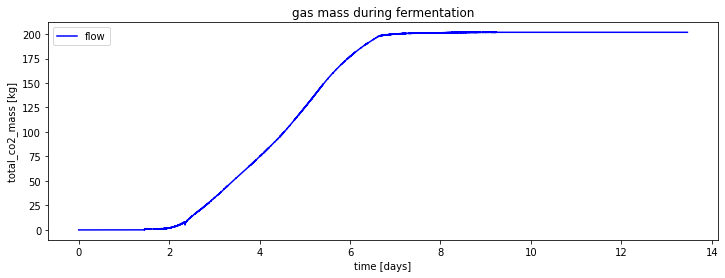

In [26]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, total_co2_mass, color="blue", label="flow")
plt.xlabel('time [days]')
plt.ylabel('total_co2_mass [kg]')
plt.legend()
plt.show()

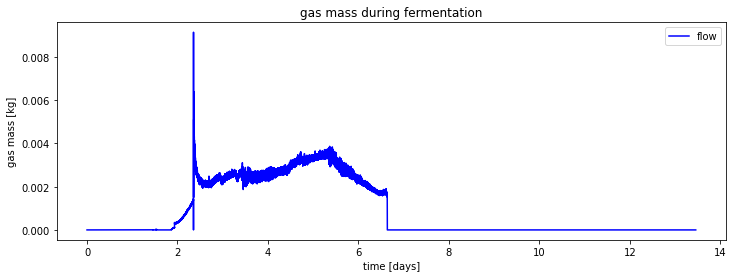

In [27]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, flow_mass, color="blue", label="flow")
plt.xlabel('time [days]')
plt.ylabel('gas mass [kg]')
plt.legend()
plt.show()

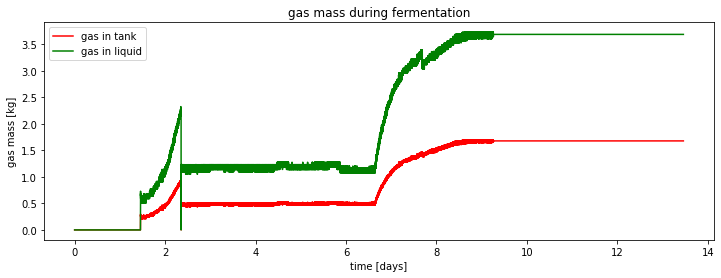

In [28]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, air_mass, color="red", label="gas in tank")
plt.plot(time_days, gas_in_liquid_mass, color="green", label="gas in liquid")
plt.xlabel('time [days]')
plt.ylabel('gas mass [kg]')
plt.legend()
plt.show()

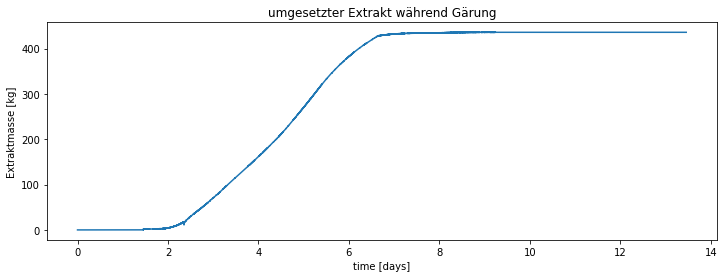

In [29]:
plt.figure(figsize=(12,4))
plt.title('umgesetzter Extrakt während Gärung')
plt.plot(time_days, extract_mass_converted)
plt.xlabel('time [days]')
plt.ylabel('Extraktmasse [kg]')
plt.show()

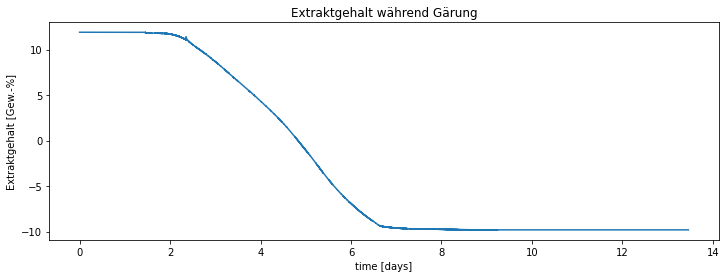

In [30]:
plt.figure(figsize=(12,4))
plt.title('Extraktgehalt während Gärung')
plt.plot(time_days, extraktgehalt)
plt.xlabel('time [days]')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.show()

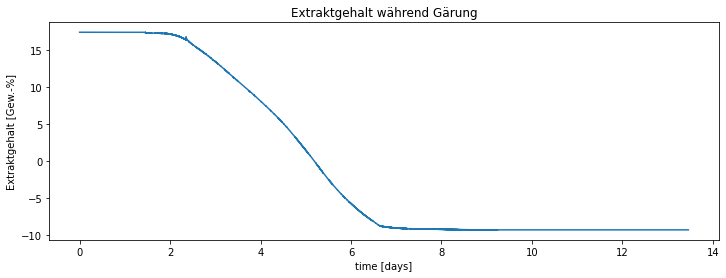

In [31]:
plt.figure(figsize=(12,4))
plt.title('Extraktgehalt während Gärung')
plt.plot(time_days, extraktgehalt_scheinbar_1)
plt.xlabel('time [days]')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.show()

NameError: name 'extraktgehalt_scheinbar_2' is not defined

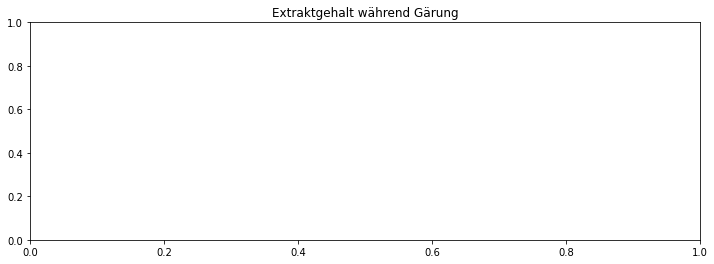

In [32]:
plt.figure(figsize=(12,4))
plt.title('Extraktgehalt während Gärung')
plt.plot(time_days, extraktgehalt_scheinbar_2)
plt.xlabel('time [days]')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.show()

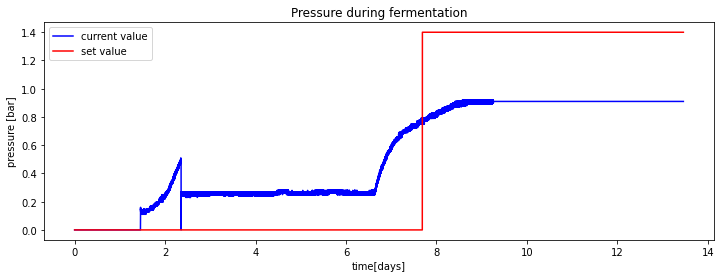

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Pressure during fermentation')
plt.plot(time_days, pressure, color="blue", label="current value")
plt.plot(time_days, pressure_set, color="red", label="set value")
plt.xlabel('time[days]')
plt.ylabel('pressure [bar]')
plt.legend()
plt.show()


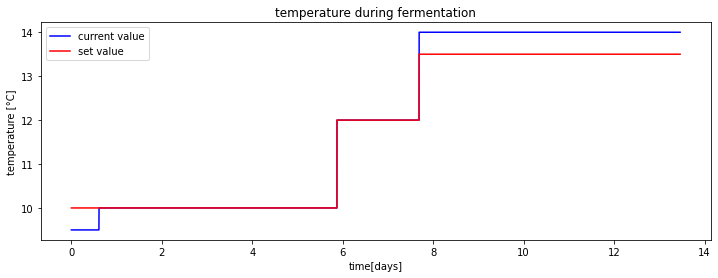

In [ ]:
plt.figure(figsize=(12,4))
plt.title('temperature during fermentation')
plt.plot(time_days, temperature, color="blue", label="current value")
plt.plot(time_days, temperature_set, color="red", label="set value")
plt.xlabel('time[days]')
plt.ylabel('temperature [°C]')
plt.legend()
plt.show()

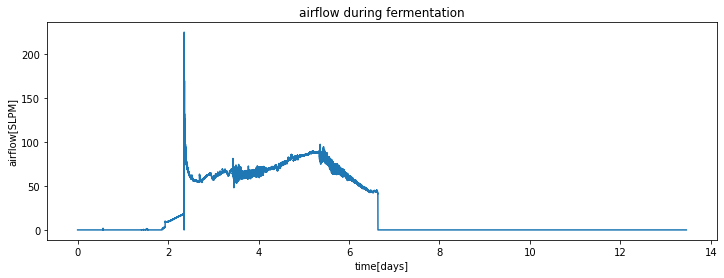

In [ ]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days,airflow)
plt.xlabel('time[days]')
plt.ylabel('airflow[SLPM]')
plt.show()

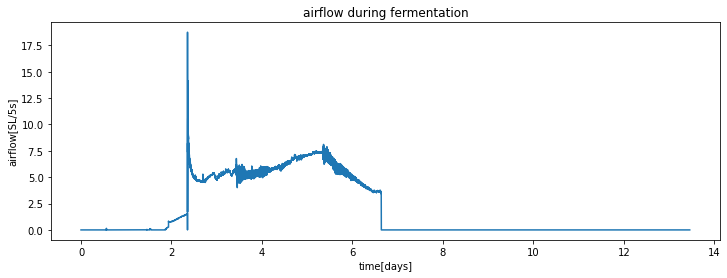

In [ ]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days,airflow_5s)
plt.xlabel('time[days]')
plt.ylabel('airflow[SL/5s]')
plt.show()

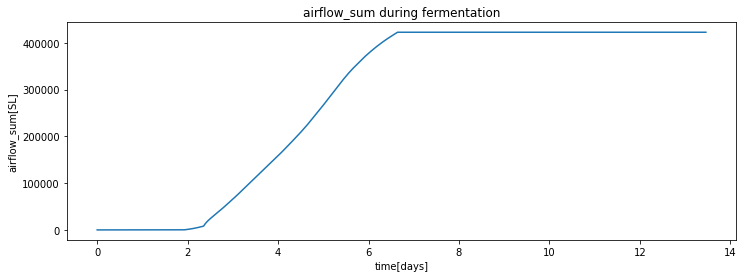

In [ ]:
plt.figure(figsize=(12,4))
plt.title('airflow_sum during fermentation')
plt.plot(time_days,airflow_sum)
plt.xlabel('time[days]')
plt.ylabel('airflow_sum[SL]')
plt.show()

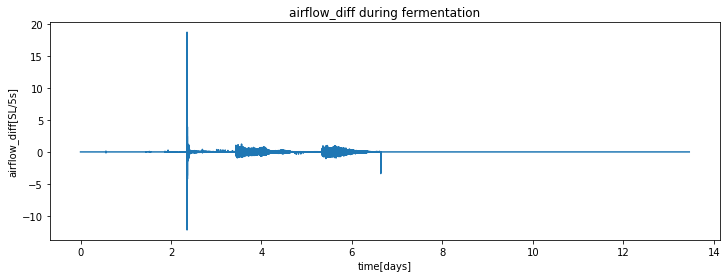

In [ ]:
plt.figure(figsize=(12,4))
plt.title('airflow_diff during fermentation')
plt.plot(time_days,airflow_diff)
plt.xlabel('time[days]')
plt.ylabel('airflow_diff[SL/5s]')
plt.show()